In [160]:
import requests
import json
import time
RETRY_TIME = 5

In [12]:
video_id = "258310143"
client_id = "jzkbprff40iqj646a697cyrvl0zt2m6"

In [34]:
def twitch_get_video_info(video_id):
    cnt = 0
    while True:
        try:
            cnt += 1
            req = requests.get("https://api.twitch.tv/helix/videos", headers={"client-id":client_id}, params={"id":video_id} )
            break
        except:
            if cnt > RETRY_TIME:
                raise
    return req.json()['data'][0]

video_info = twitch_get_video_info(video_id)

In [37]:
def duration_str_to_seconds(d_str):
    ans = 0
    tmp = d_str.split('h')
    if len(tmp) > 1:
        ans += int(tmp[0]) * 3600
        d_str = tmp[1]
    
    tmp = d_str.split('m')
    if len(tmp) > 1:
        ans += int(tmp[0]) * 60
        d_str = tmp[1]
    
    tmp = d_str.split('s')
    if len(tmp) > 1:
        ans += int(tmp[0])
    
    return ans

video_length = duration_str_to_seconds(video_info['duration'])

In [236]:
from multiprocessing import Pool
import math
PROCESS_NUM = 1

def twitch_crawl_chat_in_interval(args):
    video_id, start, end = args
    url = "https://api.twitch.tv/v5/videos/%s/comments" % video_id
    cnt = 0
    while True:
        try:
            cnt +=1
            req = requests.get(url, headers={"client-id":client_id}, params={"content_offset_seconds":start})
            break
        except:
            if cnt > RETRY_TIME:
                raise
    comments = []
    while True:
        json_data = req.json()
        if len(json_data['comments']) == 0:
            break
        comments += json_data['comments']
        if comments[-1]['content_offset_seconds'] >= end or not '_next' in json_data:
            break
        cursor_str = json_data['_next']
        cnt = 0
        while True:
            try:
                cnt += 1
                req = requests.get(url, headers={"client-id":client_id}, params={"cursor":cursor_str})
                break
            except:
                if cnt > RETRY_TIME:
                    raise
    if len(comments) > 0:
        n = 0
        while n < len(comments) and comments[-n-1]['content_offset_seconds'] >= end:
            n += 1
        if n > 0:
            comments = comments[:-n]
        n = 0
        while n < len(comments) and comments[n]['content_offset_seconds'] < start:
            n += 1
        comments = comments[n:]
    return comments

def twitch_crawl_chat(video_id):
    video_info = twitch_get_video_info(video_id)
    video_length = duration_str_to_seconds(video_info['duration'])
    step = math.ceil(video_length / PROCESS_NUM)
    pool = Pool(PROCESS_NUM)
    chats = pool.map(twitch_crawl_chat_in_interval, [(video_id, s, s+step) for s in range(0, video_length, step)])
    pool.close()
    pool.join()
    chats = sum(chats, [])
    return chats
    
    

# chats = crawl_chat(video_id)
# print(len(chats))

In [ ]:
start = time.time()
chats = twitch_crawl_chat("256588269")
end = time.time()
print("Finish in", end-start)
with open("256588269_chat.txt", "w") as fout:
    json.dump(chats, fout)
print(len(chats))

In [9]:
def twitch_get_user_profile(login_name_list):
    cnt = 0
    while True:
        try:
            cnt += 1
            req = requests.get("https://api.twitch.tv/helix/users/", headers={"client-id":client_id}, params={"login":login_name})
            break
        except:
            if cnt > RETRY_TIME:
                raise
    return req.json()['data']

#user = get_user_profile("epicenter_en1")
#print(user)

In [10]:
def twitch_get_user_clips(user_id):
    params = {"broadcaster_id":user_id, "first":100}
    clips = []
    while True:
        cnt = 0
        while True:
            try:
                cnt += 1
                req = requests.get("https://api.twitch.tv/helix/clips/", headers={"client-id":client_id}, params = params)
                break
            except:
                if cnt > RETRY_TIME:
                    raise
        json_data = req.json()
        clips += json_data['data']
        if 'cursor' in json_data["pagination"]:
            cursor = json_data["pagination"]['cursor']
            params['after'] = cursor
        else:
            break
    return clips

#clips = get_user_clips(user['id'])
#print(len(clips))

In [11]:
def twitch_get_game_info(game_id_list):
    cnt = 0
    while True:
        try:
            cnt += 1
            req = requests.get("https://api.twitch.tv/helix/games/", headers={"client-id":client_id}, params={"id":game_id_list})
            break
        except:
            if cnt > RETRY_TIME:
                raise
    return req.json()['data']

#twitch_get_game_info(["32399", "29595"])

In [13]:
import clip
clips = clip.Clip.get_top("epicenter_en1")

Got 97 clips from 5 videos.
Got 195 clips from 7 videos.
Got 288 clips from 9 videos.


In [26]:
related_clips = []
for i in range(len(clips)):
    if clips[i].video_id == video_id:
        related_clips.append(clips[i])
related_clips = sorted(related_clips, key = lambda x: x.video_offset)

In [30]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt 

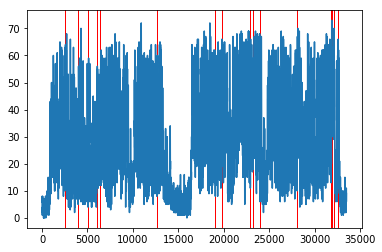

In [83]:
def plot_chats_density(chats, clips, video_length, sample_window_size = 10):
    pos = 0
    n = len(chats)
    plot_x = range(0, video_length, sample_window_size)
    plot_y = [0 for i in range(len(plot_x))]
    for offset in range(0, video_length, sample_window_size):
        cnt = 0
        while pos < n and chats[pos]['content_offset_seconds'] < offset + sample_window_size:
            pos += 1
            cnt += 1
        plot_y[int(offset / sample_window_size)] = cnt
    for clip in clips:
        plt.axvspan(clip.video_offset, clip.video_offset + clip.duration, facecolor='r')
    plt.plot(plot_x, plot_y)
    return plot_y

sample_window_size = 5
chats_density = plot_chats_density(chats, related_clips, video_length, sample_window_size)
plt.show()

In [84]:
import numpy as np

chats_density = np.asarray(chats_density)
chats_mean_density = np.mean(chats_density)
print(chats_mean_density)
clip_window = []
for clip in related_clips:
    for offset in range(clip.video_offset, int(clip.video_offset + clip.duration), sample_window_size):
        clip_window.append(offset // sample_window_size)
clip_window = np.asarray(clip_window)
clip_mean_density = np.mean(chats_density[clip_window])
print(clip_mean_density)

27.586690540137273
43.42440801457195


In [97]:
def highlight_by_threshold(chats_density, threshold):
    highlight_clips = []
    start = 0
    end = -1
    for i in range(len(chats_density)):
        if chats_density[i] > threshold:
            if i - end > 2:
                if end > start:
                    highlight_clips.append((start, end + 1))
                start = end = i
            else:
                end = i
    if end > start:
        highlight_clips.append((start, end + 1))
    return highlight_clips

filter_seg = highlight_by_threshold(chats_density, clip_mean_density)

In [113]:
related_clips_by_views = sorted(related_clips, key=lambda x:-x.views)
related_clips_by_views_corresponding_window = []
for clip in related_clips_by_views:
    tmp = []
    for offset in range(clip.video_offset, int(clip.video_offset + clip.duration), sample_window_size):
        tmp.append(offset // sample_window_size)
    related_clips_by_views_corresponding_window.append(tmp)
    
for top in [3, 10, 20, 50, len(related_clips_by_views_corresponding_window)]:
    print(np.mean(chats_density[sum(related_clips_by_views_corresponding_window[:top], [])]))

46.23529411764706
41.62
43.9
44.78512396694215
43.42440801457195


In [129]:
for i in np.argsort(chats_density)[-10:]:
    print(chats_density[i], i in sum(related_clips_by_views_corresponding_window,[]))

69 False
69 False
69 False
69 False
70 False
70 False
70 False
72 False
72 False
73 True


In [98]:
from IPython.display import HTML
def twitch_play_video(video_id, offset):
    html_str = '<iframe src="https://player.twitch.tv/?autoplay=false&t=%ds&video=%s" frameborder="0" allowfullscreen="true" scrolling="no" height="378" width="620"></iframe>' % (offset, video_id)
    return HTML(data=html_str)

twitch_play_video(video_id, related_clips[0].video_offset)

In [132]:
video_id

'258310143'

In [138]:
chats[73]

{'_id': 'ba243db6-65bf-4f6f-a590-1561b0684376',
 'channel_id': '118170488',
 'commenter': {'_id': '25634423',
  'bio': None,
  'created_at': '2011-10-22T21:18:21.990406Z',
  'display_name': 'sprakcity',
  'logo': 'https://static-cdn.jtvnw.net/user-default-pictures/bb97f7e6-f11a-4194-9708-52bf5a5125e8-profile_image-300x300.jpg',
  'name': 'sprakcity',
  'type': 'user',
  'updated_at': '2018-05-06T16:33:45.949331Z'},
 'content_id': '258310143',
 'content_offset_seconds': 81.492,
 'content_type': 'video',
 'created_at': '2018-05-06T09:27:39.292Z',
 'message': {'body': 'admiralC TI WINNER SUBS admiralC',
  'emoticons': [{'_id': '617641', 'begin': 0, 'end': 7},
   {'_id': '617641', 'begin': 24, 'end': 31}],
  'fragments': [{'emoticon': {'emoticon_id': '617641', 'emoticon_set_id': ''},
    'text': 'admiralC'},
   {'text': ' TI WINNER SUBS '},
   {'emoticon': {'emoticon_id': '617641', 'emoticon_set_id': ''},
    'text': 'admiralC'}],
  'is_action': False,
  'user_color': '#1E90FF'},
 'more_re

In [140]:
[1,2,3][:-0]

[]